In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML

import numpy as np
import numpy.linalg as la
from scipy.integrate import RK45

import sympy as sym
# Heaviside numerics workaround
from sympy.utilities.lambdify import implemented_function
lambdafied_heaviside = implemented_function('H', lambda x: np.heaviside(x,0.5))
def heaviside_sub(expr):
    return expr.subs(sym.Heaviside, lambdafied_heaviside)

from table_maker import *
from functools import partial, reduce
from itertools import *
from math import ceil

import pickle

def cos_bell(x, center=0, width=2*np.pi, height=1):
    return (np.cos((x-center)/width*2*np.pi)+1)/2*height * np.heaviside(x-center+width/2,0) * np.heaviside(-x+center+width/2,0)

import collections.abc
def collect_eqn(expr, terms):
    if not isinstance(terms, collections.abc.Container):
        term = terms # isn't a list or tuple
        left, right = 0,0
        for my_expr in expr.args:
            has_term = False
            for my_term in sym.postorder_traversal(my_expr):
                if term == my_term:
                    has_term = True
                    break
            if has_term:
                left += my_expr
            else:
                right -= my_expr
        return sym.Eq(left, right, evaluate=False)
    else: # isn't a list or tuple
        left_total, right_total = 0, expr
        for term in terms:
            left, right = collect_eqn(right_total, term).args
            left_total += left
            right_total = -right
        return sym.Eq(left_total, right_total, evaluate=False)
    
def my_print(expr):
    global eviron_print_tex
    if eviron_print_tex:
        print('$$' + sym.latex(expr) + '$$')
    else:
        display(expr)
        
def batch_print(expr_list, punctuation='.'):
    global eviron_print_tex
    if eviron_print_tex:
        print_str = '$$\\begin{align*}\n'
        for expr in expr_list:
            print_str += '\t' + sym.latex(expr).replace('=','&=') + '\\\\\n'
        # remove last new-line and add ending puncuation
        print_str = print_str[:-3] + punctuation + '\n'
        print_str += '\\end{align*}$$'
        print(print_str)
    else:
        for expr in expr_list:
            display(expr)
            
def py_code(expr, replace_numpy=True, replace_unicode=True, numpy_package='np.'):
    code = sym.ccode(expr)
    
    if replace_unicode:
        unicode_replacements = [
            ('\\alpha', 'α'),
            ('\\beta', 'β'),
            ('\\gamma', 'γ'),
            ('\\Gamma', 'Γ'),
            ('\\delta', 'δ'),
            ('\\Delta', 'Δ'),
            ('\\epsilon', 'ϵ'),
            ('\\zeta', 'ζ'),
            ('\\eta', 'η'),
            ('\\theta', 'θ'),
            
        ]
        for unicode, symbol in unicode_replacements:
            code = code.replace(unicode, symbol)
    
    if replace_numpy:
        numpy_replacements = [
            ('exp', numpy_package + 'exp'),
            ('log', numpy_package + 'log'),
            ('pow', '( lambda base, exponent: base**exponent )')
        ]
        for c_func, np_func in numpy_replacements:
            code = code.replace(c_func, np_func)
        
    return code

In [2]:
import matplotlib
matplotlib.rcParams.update({'font.size': 24})

From [Kilpatrick and Bressloff 2010](https://doi.org/10.1016/j.physd.2009.06.003)
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,x^\prime) q(x^\prime,t) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    q_t &= \frac{1 - q}{\alpha} - \beta q f(u - a) \\
    \epsilon a_t &= -a + \gamma f(u - a)
\end{align*}$$

Modified version - remove synaptic depression $q$
$$\begin{align*}
    \mu u_t &= -u + \int_{-\infty}^\infty w(x,x^\prime) f( u(x^\prime,t) - a(x^\prime,t)) \ dx^\prime \\
    \alpha a_t &= -a + \gamma f(u - a)
\end{align*}$$
(note that parameters have been relabeled)

Beginning at (Kilpatrick & Bressloff 2010)[https://www.sciencedirect.com/science/article/abs/pii/S0167278909001833] equations 3.30 and 3.31. We will use the same notation they use (i.e. we will use the $\alpha$ and $\epsilon$ they use and substitute back to our notation later. Additionally, sympy uses $\theta$ to denote the Heaviside function. We will thus use $\tau$ to denote the threshold here.

In [69]:
eviron_print_tex = False

μ, α, γ, τ, c, Δ = sym.symbols('\\mu \\alpha \\gamma, \\tau, c \\Delta', real=True, positive = True)
x, xp, t, ξ, ξp = sym.symbols('x x^\\prime t \\xi \\xi^\\prime', real=True)
u = sym.Function('u', real=True)(x,t)
a = sym.Function('u', real=True)(x,t)
U = sym.Function('U', real=True)(ξ)
A = sym.Function('A', real=True)(ξ)

G = sym.integrate( sym.Heaviside(ξp-ξ)*sym.exp(ξ-ξp) + sym.Heaviside(ξ-ξp)*sym.exp(ξp-ξ), (ξp, -Δ, 0) )/2

# F_right = sym.exp(-ξ) - sym.exp(-ξ-Δ)
# F_mid = 2 - sym.exp(ξ) - sym.exp(-ξ-Δ)
# F_left = sym.exp(ξ+Δ) - sym.exp(ξ)
# F = (F_right*sym.Heaviside(ξ) + F_mid*sym.Heaviside(ξ+Δ)*sym.Heaviside(-ξ) + F_left*sym.Heaviside(-ξ-Δ))/2
# G = F

eqn1 = μ*c*U.diff(ξ) - U + G
eqn2 = α*c*A.diff(ξ) - A + γ*( sym.Heaviside(ξ+Δ) - sym.Heaviside(ξ) )


print('Evaluating the integral, we then obtain')
batch_print( [sym.Eq(0, eqn1), sym.Eq(0, eqn2)] )

print('We will solve each system using Laplace transforms')
s = sym.symbols('s', real=True, positive=True)
Leqn1, eqn1_domain, _ = sym.laplace_transform(eqn1, ξ, s)
Leqn2, eqn2_domain, _ = sym.laplace_transform(eqn2, ξ, s)
# manually apply L(U') = s*L(U) - U(0)
LUsym = sym.laplace_transform(U, ξ, s)
Leqn1 = Leqn1.subs(sym.laplace_transform(U.diff(ξ), ξ, s), s*LUsym - U.subs(ξ,0))
LAsym = sym.laplace_transform(A, ξ, s)
Leqn2 = Leqn2.subs(sym.laplace_transform(A.diff(ξ), ξ, s), s*LAsym - A.subs(ξ,0))

batch_print( [sym.Eq(0, Leqn1), sym.Eq(0, Leqn2)], punctuation='')
print('which are jointly true on the domain $s>%s$.' % sym.latex(sym.Max(eqn1_domain, eqn2_domain)) )

print('Solving for the Laplace transform variables we have')

LU_sub = sym.solve(Leqn1, LUsym)[0]
LA_sub = sym.solve(Leqn2, LAsym)[0]

batch_print( [sym.Eq(LUsym, LU_sub), sym.Eq(LAsym, LA_sub)], punctuation='')

print('Applying the inverse Laplace transform then gives us the solutions for $\\xi > 0$')

U_sub = sym.inverse_laplace_transform(LU_sub, s, ξ)
A_sub = sym.inverse_laplace_transform(LA_sub, s, ξ)

batch_print( [sym.Eq(U, U_sub), sym.Eq(A, A_sub)], punctuation='')
print('and thus')
batch_print([sym.Eq( U-A, (U_sub - A_sub).collect(sym.exp(ξ/μ/c)) )])

print('The right boundary condition then gives')
cond1 = sym.limit(U_sub.subs( U.subs(ξ, 0), τ ) - A_sub.subs( A.subs(ξ,0), 0) , ξ, sym.oo).args[1].args[0]
cond1 = cond1.collect(sym.exp(Δ)).collect(τ).collect(2)

batch_print([sym.Eq(0, A.subs(ξ,0)), sym.Eq(0, cond1)])

print('Or equivalently,')
Δ_sub = sym.solve(cond1, Δ)[0]
c_sub = sym.solve(cond1, c)[0]

batch_print([sym.Eq(c, c_sub), sym.Eq(Δ, Δ_sub)])

print('The threshold-crossing condition also gives $U(0) = \\tau$. Our solutions and conditions then become')

U_right = U_sub.subs( U.subs(ξ,0), τ  ).subs( A.subs(ξ,0), 0 )
A_right = A_sub.subs( U.subs(ξ,0), τ  ).subs( A.subs(ξ,0), 0 )
cond1 = cond1.subs( U.subs(ξ,0), τ  ).subs( A.subs(ξ,0), 0 )


batch_print( [sym.Eq(U, sym.Piecewise((U_right, ξ>0))), sym.Eq(A, sym.Piecewise((A_right, ξ>0))), sym.Eq(0, cond1)] )


print('To get solutions for $\\xi < 0$, we will make the substitution $\\zeta = -\\xi $ and use the variables V(\\zeta) = U(\\xi), and B(\\zeta) = A(\\xi).')
print('Our equations become')

ζ = sym.symbols('\\zeta', real=True)
V = sym.Function('V')(ζ)
B = sym.Function('B')(ζ)
eqn1V = eqn1.subs(U.diff(ξ), -V.diff(ζ)).subs(U, V).subs(ξ, -ζ)#.subs(Δ, -Δ)
eqn2B = eqn2.subs(A.diff(ξ), -B.diff(ζ)).subs(A, B).subs(ξ, -ζ)#.subs(Δ, -Δ)

batch_print([sym.Eq(0, eqn1V), sym.Eq(0, eqn2B)])

print('We take the Laplace transform with respect to $\\zeta$ now, to obtain')

Leqn1V, eqn1V_domain, _ = sym.laplace_transform(eqn1V, ζ, s)
LVsym = sym.laplace_transform(V, ζ, s)
V0 = τ #V(0) = U(0) = \tau
Leqn1V = Leqn1V.subs(sym.laplace_transform(V.diff(ζ), ζ, s), s*LVsym - V0)

Leqn2B, eqn2B_domain, _ = sym.laplace_transform(eqn2B, ζ, s)
LBsym = sym.laplace_transform(B, ζ, s)
B0 = 0 #B(0) = A(0) = 0
Leqn2B = Leqn2B.subs(sym.laplace_transform(B.diff(ζ), ζ, s), s*LBsym - B0) 

batch_print([sym.Eq(0, Leqn1V), sym.Eq(0, Leqn2B)], punctuation='')

print('Next, we solve for the transformed varialbes')

LV_sub = sym.solve(Leqn1V, LVsym)[0]
LB_sub = sym.solve(Leqn2B, LBsym)[0] 

batch_print([sym.Eq(LVsym, LV_sub), sym.Eq(LBsym, LB_sub)], punctuation='')

print('and apply an inverse transform')

#need to manually partial fraction decomp - sympy is struggling
coeff = -(μ*c*s + 1)
LV_sub_rational1 = 1/(s-1)/2
LV_sub_rational2 = 1/s/(s+1)/2
expr = LV_sub_rational1*(1 - sym.exp(-Δ)) + LV_sub_rational2 * (1 - sym.exp(-Δ*s)) + μ*c*V0
expr += coeff * LVsym
assert expr.expand() - Leqn1V.expand() == 0 # properly factored expression
Apfd = -1/(1+c*μ)/2
Bpfd = Apfd + sym.Rational(1,2)
LV_sub_pfd1 = Apfd/(s-1) + Bpfd/(1+c*μ*s)
assert (LV_sub_pfd1 - LV_sub_rational1/coeff).simplify() == 0
Apfd = -sym.Rational(1,2)
Bpfd = -Apfd/(1-μ*c)
Dpfd = -Bpfd - Apfd*(1+μ*c)
LV_sub_pfd2 = Apfd/s + Bpfd/(s+1) + Dpfd/(1+μ*c*s)
assert (LV_sub_pfd2 - LV_sub_rational2/coeff).simplify() == 0
LV_sub = -(LV_sub_pfd1*(1-sym.exp(-Δ)) + LV_sub_pfd2*(1-sym.exp(-Δ*s)) + μ*c*V0/coeff)
assert Leqn1V.subs(LVsym, LV_sub).simplify() == 0 # partial fraction decomposition satisfies the condition
# sympy refuses to find the inverse laplace transform of the fourth term in this sum
terms = [-LV_sub_pfd1, LV_sub_pfd1*sym.exp(-Δ), - LV_sub_pfd2,  LV_sub_pfd2*sym.exp(-Δ*s), - μ*c*V0/coeff]
term3 = sum([arg*sym.exp(-Δ*s) for arg in terms[3].args[0].args])

new_terms = [term for i,term in enumerate(terms) if i!=3] + [term3]
assert (sum(new_terms) - sum(terms)).simplify() == 0 # we have refactored the expression correctly
V_sub = sum(sym.inverse_laplace_transform(term, s, ζ) for term in new_terms).collect(sym.Heaviside(ζ)).collect(sym.Heaviside(-Δ+ζ))

factor1 = reduce(lambda x, y: x*y, LB_sub.args[:3])
factor2 = reduce(lambda x, y: x*y, LB_sub.args[3:]).expand()
expr = sum(term*factor1 for term in factor2.args)
assert (expr - LB_sub).simplify() == 0
B_sub = sym.inverse_laplace_transform(expr, s, ζ).collect(sym.Heaviside(ζ)).collect(sym.Heaviside(-Δ+ζ))

batch_print([sym.Eq(V, V_sub), sym.Eq(B, B_sub)])

print('Substituting back $\\zeta \\to -\\xi$, and adding combining we have our final answer')

U_final = U_right.collect(sym.Heaviside(ξ)) + V_sub.subs(ζ, -ξ)
A_final = B_sub.subs(ζ, -ξ) + A_right

batch_print([sym.Eq(U, U_final), sym.Eq(A, A_final)])

Evaluating the integral, we then obtain


Eq(0, \mu*c*Derivative(U(\xi), \xi) + (1 - exp(\xi))*Heaviside(-\xi)/2 - (1 - exp(\Delta + \xi))*Heaviside(-\Delta - \xi)/2 - U(\xi) - exp(-\Delta - \xi)/2 + exp(-\xi)/2)

Eq(0, \alpha*c*Derivative(A(\xi), \xi) + \gamma*(-Heaviside(\xi) + Heaviside(\Delta + \xi)) - A(\xi))

We will solve each system using Laplace transforms


Eq(0, \mu*c*(s*LaplaceTransform(U(\xi), \xi, s) - U(0)) - LaplaceTransform(U(\xi), \xi, s) + 1/(2*(s + 1)) - exp(-\Delta)/(2*(s + 1)))

Eq(0, \alpha*c*(s*LaplaceTransform(A(\xi), \xi, s) - A(0)) - LaplaceTransform(A(\xi), \xi, s))

which are jointly true on the domain $s>0$.
Solving for the Laplace transform variables we have


Eq(LaplaceTransform(U(\xi), \xi, s), (2*\mu*c*(s + 1)**2*U(0)*exp(\Delta) - s*exp(\Delta) + s - exp(\Delta) + 1)*exp(-\Delta)/(2*(s + 1)**2*(\mu*c*s - 1)))

Eq(LaplaceTransform(A(\xi), \xi, s), \alpha*c*A(0)/(\alpha*c*s - 1))

Applying the inverse Laplace transform then gives us the solutions for $\xi > 0$


Eq(U(\xi), (2*\mu*c*U(0)*exp(\xi/(\mu*c)) + 2*U(0)*exp(\xi/(\mu*c)) - exp(\xi/(\mu*c)) - exp(-\Delta - \xi) + exp(-\Delta + \xi/(\mu*c)) + exp(-\xi))*Heaviside(\xi)/(2*(\mu*c + 1)))

Eq(A(\xi), A(0)*exp(\xi/(\alpha*c))*Heaviside(\xi))

and thus


Eq(-A(\xi) + U(\xi), -A(0)*exp(\xi/(\alpha*c))*Heaviside(\xi) + ((2*\mu*c*U(0) + 2*U(0) - 1 + exp(-\Delta))*exp(\xi/(\mu*c)) - exp(-\Delta - \xi) + exp(-\xi))*Heaviside(\xi)/(2*(\mu*c + 1)))

The right boundary condition then gives


Eq(0, A(0))

Eq(0, (2*\tau*(\mu*c + 1) - 1)*exp(\Delta) + 1)

Or equivalently,


Eq(c, (-2*\tau*exp(\Delta) + exp(\Delta) - 1)*exp(-\Delta)/(2*\mu*\tau))

Eq(\Delta, log(-1/(2*\mu*\tau*c + 2*\tau - 1)))

The threshold-crossing condition also gives $U(0) = \tau$. Our solutions and conditions then become


Eq(U(\xi), Piecewise(((2*\mu*\tau*c*exp(\xi/(\mu*c)) + 2*\tau*exp(\xi/(\mu*c)) - exp(\xi/(\mu*c)) - exp(-\Delta - \xi) + exp(-\Delta + \xi/(\mu*c)) + exp(-\xi))*Heaviside(\xi)/(2*(\mu*c + 1)), \xi > 0)))

Eq(A(\xi), Piecewise((0, \xi > 0)))

Eq(0, (2*\tau*(\mu*c + 1) - 1)*exp(\Delta) + 1)

To get solutions for $\xi < 0$, we will make the substitution $\zeta = -\xi $ and use the variables V(\zeta) = U(\xi), and B(\zeta) = A(\xi).
Our equations become


Eq(0, -\mu*c*Derivative(V(\zeta), \zeta) + (1 - exp(-\zeta))*Heaviside(\zeta)/2 - (1 - exp(\Delta - \zeta))*Heaviside(-\Delta + \zeta)/2 - V(\zeta) + exp(\zeta)/2 - exp(-\Delta + \zeta)/2)

Eq(0, -\alpha*c*Derivative(B(\zeta), \zeta) + \gamma*(-Heaviside(-\zeta) + Heaviside(\Delta - \zeta)) - B(\zeta))

We take the Laplace transform with respect to $\zeta$ now, to obtain


Eq(0, -\mu*c*(-\tau + s*LaplaceTransform(V(\zeta), \zeta, s)) - LaplaceTransform(V(\zeta), \zeta, s) + 1/(2*(s - 1)) - exp(-\Delta)/(2*(s - 1)) + 1/(2*s*(s + 1)) - exp(-\Delta*s)/(2*s*(s + 1)))

Eq(0, -\alpha*c*s*LaplaceTransform(B(\zeta), \zeta, s) + \gamma/s - \gamma*exp(-\Delta*s)/s - LaplaceTransform(B(\zeta), \zeta, s))

Next, we solve for the transformed varialbes


Eq(LaplaceTransform(V(\zeta), \zeta, s), (2*\mu*\tau*c*s**3*exp(\Delta*s + \Delta) - 2*\mu*\tau*c*s*exp(\Delta*s + \Delta) - s**2*exp(\Delta*s) + s**2*exp(\Delta*s + \Delta) - s*exp(\Delta) - s*exp(\Delta*s) + 2*s*exp(\Delta*s + \Delta) + exp(\Delta) - exp(\Delta*s + \Delta))*exp(-\Delta*s - \Delta)/(2*s*(\mu*c*s**3 - \mu*c*s + s**2 - 1)))

Eq(LaplaceTransform(B(\zeta), \zeta, s), \gamma*(exp(\Delta*s) - 1)*exp(-\Delta*s)/(s*(\alpha*c*s + 1)))

and apply an inverse transform


Eq(V(\zeta), (\mu*c*exp((\Delta - \zeta)/(\mu*c))/(2*(\mu*c - 1)) - 1/2 - exp(\Delta - \zeta)/(2*\mu*c - 2))*Heaviside(-\Delta + \zeta) + (\tau*exp(-\zeta/(\mu*c)) + (-exp(\zeta) + exp(-\zeta/(\mu*c)))*exp(-\Delta)/(2*(\mu*c + 1)) + (exp(\zeta + \zeta/(\mu*c)) - 1)*exp(-\zeta/(\mu*c))/(2*(\mu*c + 1)) + (-\mu*c*exp(\zeta) + \mu*c*exp(\zeta + \zeta/(\mu*c)) + exp(\zeta/(\mu*c)) - exp(\zeta + \zeta/(\mu*c)))*exp(-\zeta - \zeta/(\mu*c))/(2*(\mu*c - 1)))*Heaviside(\zeta))

Eq(B(\zeta), \gamma*(-\Delta + \zeta + (\Delta - \zeta)*exp((\Delta - \zeta)/(\alpha*c)))*Heaviside(-\Delta + \zeta)/(\Delta - \zeta) + (\gamma - \gamma*exp(-\zeta/(\alpha*c)))*Heaviside(\zeta))

Substituting back $\zeta \to -\xi$, and adding combining we have our final answer


Eq(U(\xi), (\mu*c*exp((\Delta + \xi)/(\mu*c))/(2*(\mu*c - 1)) - 1/2 - exp(\Delta + \xi)/(2*\mu*c - 2))*Heaviside(-\Delta - \xi) + (\tau*exp(\xi/(\mu*c)) + (exp(\xi/(\mu*c)) - exp(-\xi))*exp(-\Delta)/(2*(\mu*c + 1)) + (exp(-\xi - \xi/(\mu*c)) - 1)*exp(\xi/(\mu*c))/(2*(\mu*c + 1)) + (\mu*c*exp(-\xi - \xi/(\mu*c)) - \mu*c*exp(-\xi) - exp(-\xi - \xi/(\mu*c)) + exp(-\xi/(\mu*c)))*exp(\xi + \xi/(\mu*c))/(2*(\mu*c - 1)))*Heaviside(-\xi) + (2*\mu*\tau*c*exp(\xi/(\mu*c)) + 2*\tau*exp(\xi/(\mu*c)) - exp(\xi/(\mu*c)) - exp(-\Delta - \xi) + exp(-\Delta + \xi/(\mu*c)) + exp(-\xi))*Heaviside(\xi)/(2*(\mu*c + 1)))

Eq(A(\xi), \gamma*(-\Delta - \xi + (\Delta + \xi)*exp((\Delta + \xi)/(\alpha*c)))*Heaviside(-\Delta - \xi)/(\Delta + \xi) + (-\gamma*exp(\xi/(\alpha*c)) + \gamma)*Heaviside(-\xi))

NameError: name 'μ' is not defined

# Piecewise

In [245]:
eviron_print_tex = False

μ, α, γ, τ, c, Δ = sym.symbols('\\mu \\alpha \\gamma, \\theta, c \\Delta', real=True, positive = True)
with open('profile.pickle', 'rb') as f:
    xs, Us, As, param_list = pickle.load(f)
    params = [μ, α,  γ,  τ, Δ, c]
    param_dict = {key:val for key,val in zip(params, param_list)}

x, xp, t, ξ, ξp = sym.symbols('x x^\\prime t \\xi \\xi^\\prime', real=True)
u = sym.Function('u', real=True)(x,t)
a = sym.Function('u', real=True)(x,t)
U = sym.Function('U', real=True)(ξ)
A = sym.Function('A', real=True)(ξ)

Fright = (1-sym.exp(-Δ))*sym.exp(-ξ)/2
Fmid = (2 - sym.exp(ξ) - sym.exp(-ξ-Δ)).collect(sym.exp(ξ))/2
Fleft = (sym.exp(ξ+Δ) - sym.exp(ξ)).collect(sym.exp(ξ))/2
F = (Fright*sym.Heaviside(ξ) + Fmid*sym.Heaviside(ξ+Δ)*sym.Heaviside(-ξ) + Fleft*sym.Heaviside(-ξ-Δ))/2

G =  γ*( sym.Heaviside(ξ+Δ) - sym.Heaviside(ξ) )
L = lambda f: μ*c*f.diff(ξ) - f

##########################################################
#
# Find Uright 
#
##########################################################
Uhom = sym.dsolve(L(U), U).args[1]
assert L(Uhom).simplify() == 0
temp = sym.symbols('T_{emp}')
form = sym.exp(-ξ)
temp_sub = sym.solve( L(temp*form)+Fright, temp )[0]
Upar = temp_sub*form
assert (L(Upar)+Fright).simplify() == 0
Uright = Uhom + Upar
assert (L(Uright)+Fright).simplify() == 0
C1 = sym.symbols('C1')
C1exp_sub = sym.solve(Uright.subs(ξ, 0).expand()-τ, sym.exp(C1/μ/c))[0]
Uright = Uright.expand().subs(sym.exp(C1/μ/c), C1exp_sub)
assert (L(Uright)+Fright).simplify() == 0
assert (Uright.subs(ξ,0) - τ).simplify() == 0
##########################################################
#
# Find Umid 
#
##########################################################
temp1, temp2, temp3 = sym.symbols('T1 T2 T3')
form1, form2, form3 = 1, sym.exp(-ξ), sym.exp(ξ)
ansatz = temp1*form1 + temp2*form2 + temp3*form3
Lansatz = L(ansatz).expand().collect(sym.exp(ξ))
temp1_sub = sym.solve( Lansatz.subs(temp2, 0).subs(temp3, 0) - [term for term in Fmid.args if 'exp' not in str(term)][0], temp1 )[0]
temp2_sub = sym.solve(  Lansatz.coeff(sym.exp(-ξ)) - Fmid.coeff(sym.exp(-ξ)), temp2)[0]
temp3_sub = sym.solve(  Lansatz.coeff(sym.exp(ξ)) - Fmid.coeff(sym.exp(ξ)), temp3)[0]
Upar = -temp1_sub*form1 - temp2_sub*form2 - temp3_sub*form3
assert (L(Upar) + Fmid).simplify() == 0
Umid = Uhom + Upar
C1exp_sub = sym.solve(Umid.subs(ξ, 0).expand()-τ, sym.exp(C1/μ/c))[0]
Umid = Umid.expand().subs(sym.exp(C1/μ/c), C1exp_sub)
assert (L(Umid)+Fmid).simplify() == 0
assert (Umid.subs(ξ,0) - τ).simplify() == 0

##########################################################
#
# Find Uleft 
#
##########################################################
form = sym.exp(ξ)
ansatz = L(temp*form).collect(form)
temp_sub = sym.solve( ansatz.coeff(form) - Fleft.coeff(form), temp )[0]
Upar = -temp_sub * form
assert (  L(Upar) + Fleft ).simplify() == 0
Uleft = Uhom + Upar
C1exp_sub = sym.solve( Uleft.subs(ξ,-Δ).expand() - Umid.subs(ξ,-Δ).expand(), sym.exp(C1/μ/c))[0]
Uleft = Uleft.expand().subs(sym.exp(C1/μ/c), C1exp_sub)
assert (  L(Uleft) + Fleft ).simplify() == 0
assert ( Uleft.subs(ξ,-Δ) - Umid.subs(ξ,-Δ) ).simplify() == 0
##########################################################
#
# Simplify and combine 
#
##########################################################
Uleft = Uleft.expand().collect(sym.exp(ξ)).collect(sym.exp(ξ/μ/c)).collect(sym.exp(Δ)).collect(τ).collect(1/(μ*c-1)).collect(1/(μ**2*c**2-1))
Uleft = Uleft.collect(1/(2*μ**2*c**2-2)).collect(2).collect(1/(μ**2*c**2-1))
Umid = Umid.expand().collect(sym.exp(ξ)).collect(sym.exp(ξ/μ/c)).collect(τ).collect(2).collect(sym.exp(Δ)).collect(1/(μ**2*c**2-1))
Uright = Uright.collect(sym.exp(ξ)).collect(sym.exp(ξ/μ/c)).collect(sym.exp(Δ)).collect(τ).collect(2).collect(1/(μ*c+1))
# display(Uleft)
# display(Umid)
# display(Uright)

Usub = sym.Piecewise( (Uleft, ξ<-Δ), (Umid, ξ<0), (Uright, True))
##########################################################
#
# A homogeneous 
#
##########################################################
L = lambda f: α*c*f.diff(ξ) - f
Ahom = sym.dsolve(L(A), A).args[1].expand()

##########################################################
#
# A right = 0 
#
##########################################################
Aright = 0
##########################################################
#
# A middle 
#
##########################################################
G = γ
Amid = sym.dsolve(L(A) + G, ics={A.subs(ξ,0):0}).args[1].expand().collect(γ)

##########################################################
#
# A left 
#
##########################################################
C1exp = sym.solve(Ahom.subs(ξ, -Δ) - Amid.subs(ξ,-Δ), sym.exp(C1/α/c))[0]
Aleft = Ahom.subs(sym.exp(C1/α/c), C1exp)

##########################################################
#
# Combine to get A
#
##########################################################
Asub = sym.Piecewise( (Aleft, ξ<-Δ), (Amid, ξ<0), (Aright, True))

##########################################################
#
# get conditions 
#
##########################################################
cond1 = sym.limit(Uright, ξ, sym.oo).args[1].args[0].collect(sym.exp(Δ)).collect(τ).collect(2)
cond2 = (Umid - Amid).subs(ξ, -Δ) - τ
#cond2 = cond2.expand().collect(γ).collect(τ).collect(sym.exp(Δ/μ/c)).collect(sym.exp(Δ)).collect(2).collect(μ**2 * c**2 - 1)
cond2 = cond2.simplify()

Δexp_sub = sym.solve(cond1, sym.exp(Δ))[0]
cond2_c = cond2.subs(sym.exp(Δ), Δexp_sub).subs(sym.exp(Δ/μ/c), Δexp_sub**(1/μ/c)).subs(sym.exp(Δ/α/c), Δexp_sub**(1/α/c)).collect(τ).collect(2)

In [246]:
cond1

(2*\theta*(\mu*c + 1) - 1)*exp(\Delta) + 1

In [247]:
cond2

-\gamma*(1 - exp(-\Delta/(\alpha*c))) - \theta + 1 + (-\mu**2*c**2 - \mu*c/2 + \theta*(\mu**2*c**2 - 1) + (\mu*c/2 - 1/2)*exp(-\Delta) + 1/2)*exp(-\Delta/(\mu*c))/(\mu**2*c**2 - 1) - 1/(2*(\mu*c + 1)) + exp(-\Delta)/(2*(\mu*c - 1))

In [248]:
cond2_c

-\gamma*(1 - (-1/(2*\theta*(\mu*c + 1) - 1))**(-1/(\alpha*c))) - \theta + 1 - 1/(2*(\mu*c + 1)) + (2*\theta*(-\mu*c - 1) + 1)/(2*(\mu*c - 1)) + (-1/(2*\theta*(\mu*c + 1) - 1))**(-1/(\mu*c))*(-\mu**2*c**2 - \mu*c/2 + \theta*(\mu**2*c**2 - 1) + (\mu*c/2 - 1/2)*(2*\theta*(-\mu*c - 1) + 1) + 1/2)/(\mu**2*c**2 - 1)

In [251]:
var_vec = sym.Matrix([[Δ], [c]])
vecF = sym.Matrix([[cond1],[cond2]])

In [267]:
param_dict2 = {key:param_dict[key] for key in param_dict if key not in [Δ, c]}
jac = sym.lambdify( (Δ,c),  vecF.jacobian(var_vec).subs(param_dict2) )

In [271]:
jac(38, 4)

array([[ 0.00000000e+00,  6.37118635e+15],
       [-7.45847047e-03,  9.08596279e-02]])

In [264]:
param_dict2 = {key:param_dict[key] for key in param_dict if key not in [Δ, c]}

In [265]:
param_dict2

{\mu: 1, \alpha: 5, \gamma: 1, \theta: 0.1}

In [263]:
for key,val in param_dict:
    display(key)
    print(val)

TypeError: 'Symbol' object is not iterable

In [237]:
cond2.simplify().subs(sym.exp(Δ), Δexp_sub).subs(sym.exp(Δ/μ/c), Δexp_sub**(1/μ/c)).subs(sym.exp(Δ/α/c), Δexp_sub**(1/α/c))

-\gamma*(1 - (-1/(2*\mu*\theta*c + 2*\theta - 1))**(-1/(\alpha*c))) - \theta*(1 - (-1/(2*\mu*\theta*c + 2*\theta - 1))**(-1/(\mu*c))) + 1 - 1/(2*(\mu*c + 1)) + (-2*\mu*\theta*c - 2*\theta + 1)/(2*(\mu*c - 1)) - (-1/(2*\mu*\theta*c + 2*\theta - 1))**(-1/(\mu*c))*(\mu**2*c**2 + \mu*c/2 - (\mu*c - 1)*(-2*\mu*\theta*c - 2*\theta + 1)/2 - 1/2)/(\mu**2*c**2 - 1)

In [244]:
cond2_c

\gamma*(-1 + (-1/(2*\theta*(\mu*c + 1) - 1))**(-1/(\alpha*c))) + \theta*(-1 + (-1/(2*\theta*(\mu*c + 1) - 1))**(-1/(\mu*c))) + 1 - 1/(2*(\mu*c + 1)) + (2*\theta*(-\mu*c - 1) + 1)/(2*(\mu*c - 1)) + (-1/(2*\theta*(\mu*c + 1) - 1))**(-1/(\mu*c))*(-\mu**2*c**2 - \mu*c/2 + (\mu*c - 1)*(2*\theta*(-\mu*c - 1) + 1)/2 + 1/2)/(\mu**2*c**2 - 1)

In [243]:
((Umid - Amid).subs(ξ,-Δ) - τ).subs(param_dict)

-0.0141987616314172

In [241]:
Umid-Amid

-\gamma*(1 - exp(\xi/(\alpha*c))) + 1 + (-\mu**2*c**2 - \mu*c/2 + \theta*(\mu**2*c**2 - 1) + (\mu*c/2 - 1/2)*exp(-\Delta) + 1/2)*exp(\xi/(\mu*c))/(\mu**2*c**2 - 1) - exp(-\Delta)*exp(-\xi)/(2*(\mu*c + 1)) + exp(\xi)/(2*(\mu*c - 1))

In [226]:
sym.solve(cond1, Δ)[0]

log(-1/(2*\mu*\theta*c + 2*\theta - 1))

In [223]:
cond2_c_diff = sym.diff(cond2_c, c)
croot_numeric = sym.lambdify(temp, cond2.subs(c,temp).subs(param_dict))
dcroot_numeric = sym.lambdify(temp, cond2.diff(c).subs(c,temp).subs(param_dict))
my_c = param_dict[c]
for i in range(10):
    my_c -= croot_numeric(my_c)/dcroot_numeric(my_c)
    
param_dict2 = param_dict.copy()
param_dict2[c] = my_c
param_dict2[Δ] = sym.solve(cond1, Δ)[0].subs(param_dict2)

In [224]:
Utest = sym.lambdify(ξ, Usub.subs(param_dict2) )
Atest = sym.lambdify(ξ, Asub.subs(param_dict2) )
plt.plot(xs, Us, 'b-')
plt.plot(xs, Utest(xs), 'k--')
plt.plot(xs, As, 'm-')
plt.plot(xs, Atest(xs), 'k--')
plt.xlim(xs[0], xs[-1])
plt.ylim(-.1, 1.1)
plt.show()

TypeError: Invalid comparison of non-real 4.30665681913947 + I*pi

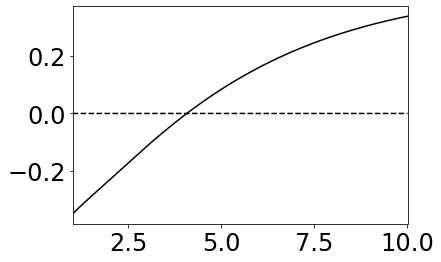

In [230]:
c_test = sym.lambdify(x, cond2.subs(c,x).subs(param_dict))
cs = np.linspace(1+np.finfo(float).eps, 10, 2001)
plt.plot(cs, [c_test(my_c) for my_c in cs],'k')
plt.xlim(cs[0], cs[-1])
plt.plot(cs, 0*cs, 'k--')
plt.show()

In [231]:
my_c

4.067392677681539

In [233]:
param_dict2[Δ]

4.30665681913947 + I*pi